Hi, our names are *Illyuvieva Alice* and *Tafintseva Albina* and we decided to write a tutirial on a subject of ***ARIMA model***. 

In this tutorial we want to illustrate how ARIMA model can be applied in python, how we can measure it's efficiency and make predictions. 

We have chosen data of COVID19, this data contains infromation about countries from 2020-01-22 : 2021-02-01. Data is collected in the way that all indicators are summed with the previous ones, so each day does not indicate the statistics of that day, put indicates the overall statictics for all pevious days since 2020-01-22. For each day for each country we can see the sum of number of people who had confirmed COVID19 (to that day), number of people who recovered (since 2020-01-22 to that day) and number of people who had died since 2020-01-22 to that day.

In the next sell below you can see all the libraries which are going to be used in order to upload data, to modify data, to construct arima model, to extract train and test parts from the data, to get predictions, to estimate the model, to visualize and so on.

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score
import sklearn.metrics as sm

...Uploading data

In [47]:
csv_url = 'time-series-19-covid-combined.csv'
data = pd.read_csv(csv_url, index_col=0, parse_dates=True, squeeze=True)

data

,Country/Region,Province/State,Confirmed,Recovered,Deaths
Date,,,,,
2020-01-22,Afghanistan,NaN,0,0.0,0
2020-01-23,Afghanistan,NaN,0,0.0,0
2020-01-24,Afghanistan,NaN,0,0.0,0
2020-01-25,Afghanistan,NaN,0,0.0,0
2020-01-26,Afghanistan,NaN,0,0.0,0
...,...,...,...,...,...
2021-01-28,Zimbabwe,NaN,32646,24419.0,1160
2021-01-29,Zimbabwe,NaN,32952,24872.0,1178
2021-01-30,Zimbabwe,NaN,33273,25361.0,1193


Now you can see visualized data. Therefore, it is time to tell you what task we want to solve and how we will need to modify data in order to complete it.

So, we decided that we want to explore statistics about deaths in Afganistan. And make predictions about number of deaths in the future. We say, that: 

H0 (null hypothesis) = number of deaths in Afganistan is going to decrease. 

1. We will take only data concerning Afganistan (trim number of rows in th dataset)
2. We will drop all columns in the resulted from '2.' dataset, apart from dates and number of deaths
3. We are going to create column 'deaths per day' in which deaths per day will be calculated smart, right?) ) - the algorithm is pretty easy and understandable from the code
 

 That's all for modifications with dataset, and below you can see the code for everything described above. 
 
 Enjoy!

In [48]:
data = data.drop(['Country/Region', 'Province/State', 'Confirmed', 'Recovered'], axis = 1)
data = data.iloc[0:377]
data

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-01-28,2397
2021-01-29,2399
2021-01-30,2400


In [49]:
new_data_deaths = list()
old_data_deaths1 = list(data['Deaths'])[1:]
old_data_deaths2 = list(data['Deaths'])[:-1]

new_data_deaths.append(list(data['Deaths'])[0])
new_data_deaths.extend(np.array(old_data_deaths1) - np.array(old_data_deaths2))

data['Deaths_per_day'] = new_data_deaths
data

,Deaths,Deaths_per_day
Date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2021-01-28,2397,8
2021-01-29,2399,2
2021-01-30,2400,1


In [50]:
data = data.drop(['Deaths'], axis = 1)
data

,Deaths_per_day
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-01-28,8
2021-01-29,2
2021-01-30,1


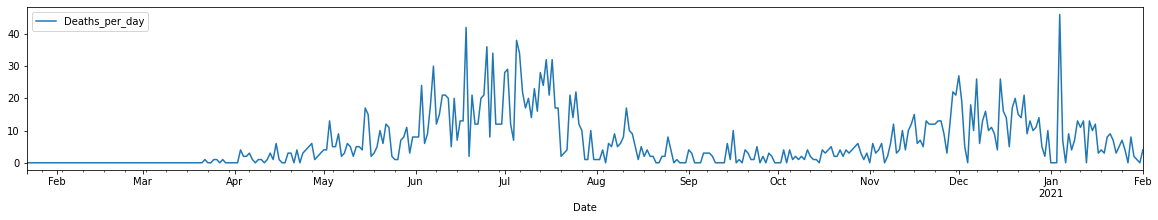

In [51]:
data.plot()

**Examine whether data is stationary or not:**

1. H0: time-series data is non-stationary
2. apply adfuller() function to our time-series
3. make conclusion (if p-value of the test is < 0.05 => reject H0)

In [52]:
result_of_adfuller = adfuller(data['Deaths_per_day'])
print('p-value: %f' % result_of_adfuller[1])

p-value: 0.286124


P-value is greater than the sighnificance level => process is non-stationary => we have to difference the series and whatch with what level of differnec we will be able to achive stationarity. 
Also it is vital to do, because when we will specificate our model, we will have to spacificate order = (p, d, q), where d stands for the level of difference.


Firstly look at the original data:

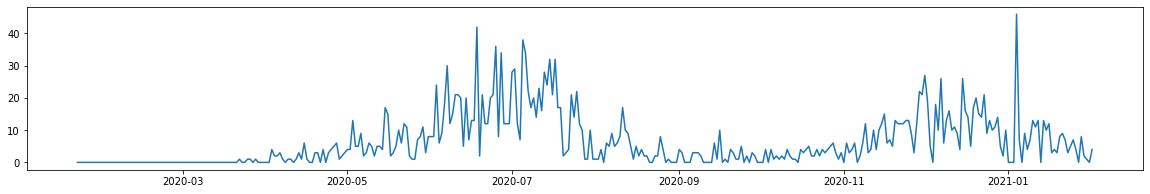

In [53]:
plt.rcParams["figure.figsize"] = (20,3)
print(plt.plot(data['Deaths_per_day']))


Now our data with the first order of differencing:

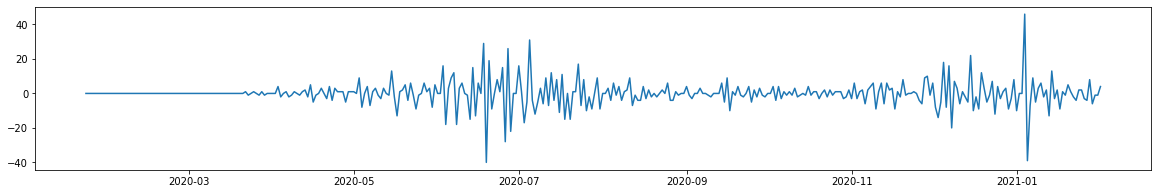

In [54]:
plt.rcParams["figure.figsize"] = (20,3)
difference_order_1 = data['Deaths_per_day'].diff()
print(plt.plot(difference_order_1))


Now our data with the second order of differencing:

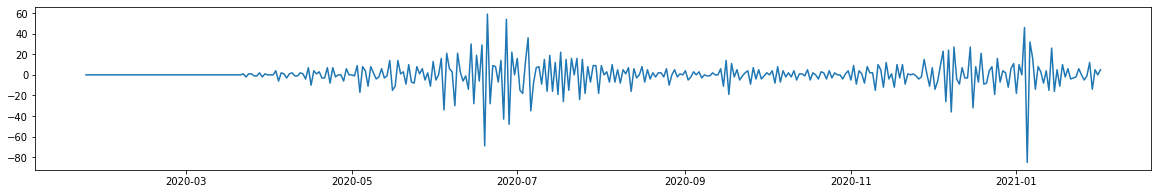

In [55]:
plt.rcParams["figure.figsize"] = (20,3)
difference_order_2 = data['Deaths_per_day'].diff().diff()
print(plt.plot(difference_order_2))


We decided to take difference level = 1, as level differnce > 1 does not make much changes

Now we specificate our model. We do not need date columns, as we are constructing ARIMA models regarding time-series data of deaths.


Lets start from finding parameters for the model. 
1. AR term (p)
2. MA term (q)
3. diff term is already found above


AR term:

required number of AR terms can be found by inspecting the Partial Autocorrelation (PACF) plot.

Figure(1440x216)
Figure(1440x216)


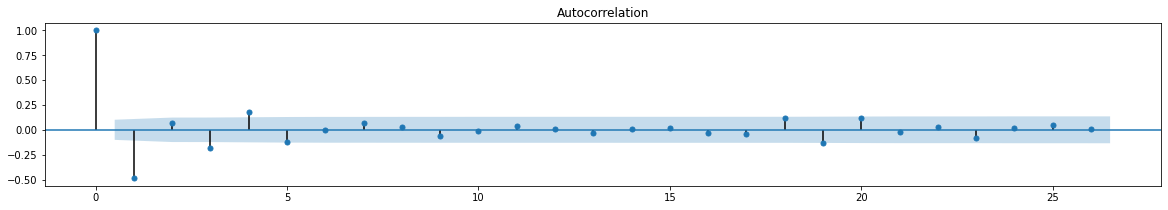

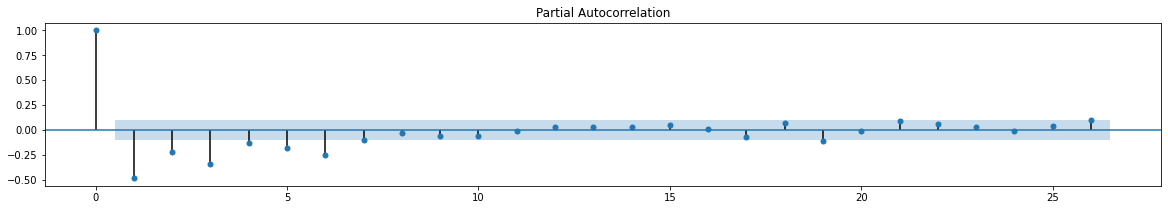

In [56]:
print(plot_acf(difference_order_1.dropna()))
print(plot_pacf(difference_order_1.dropna()))

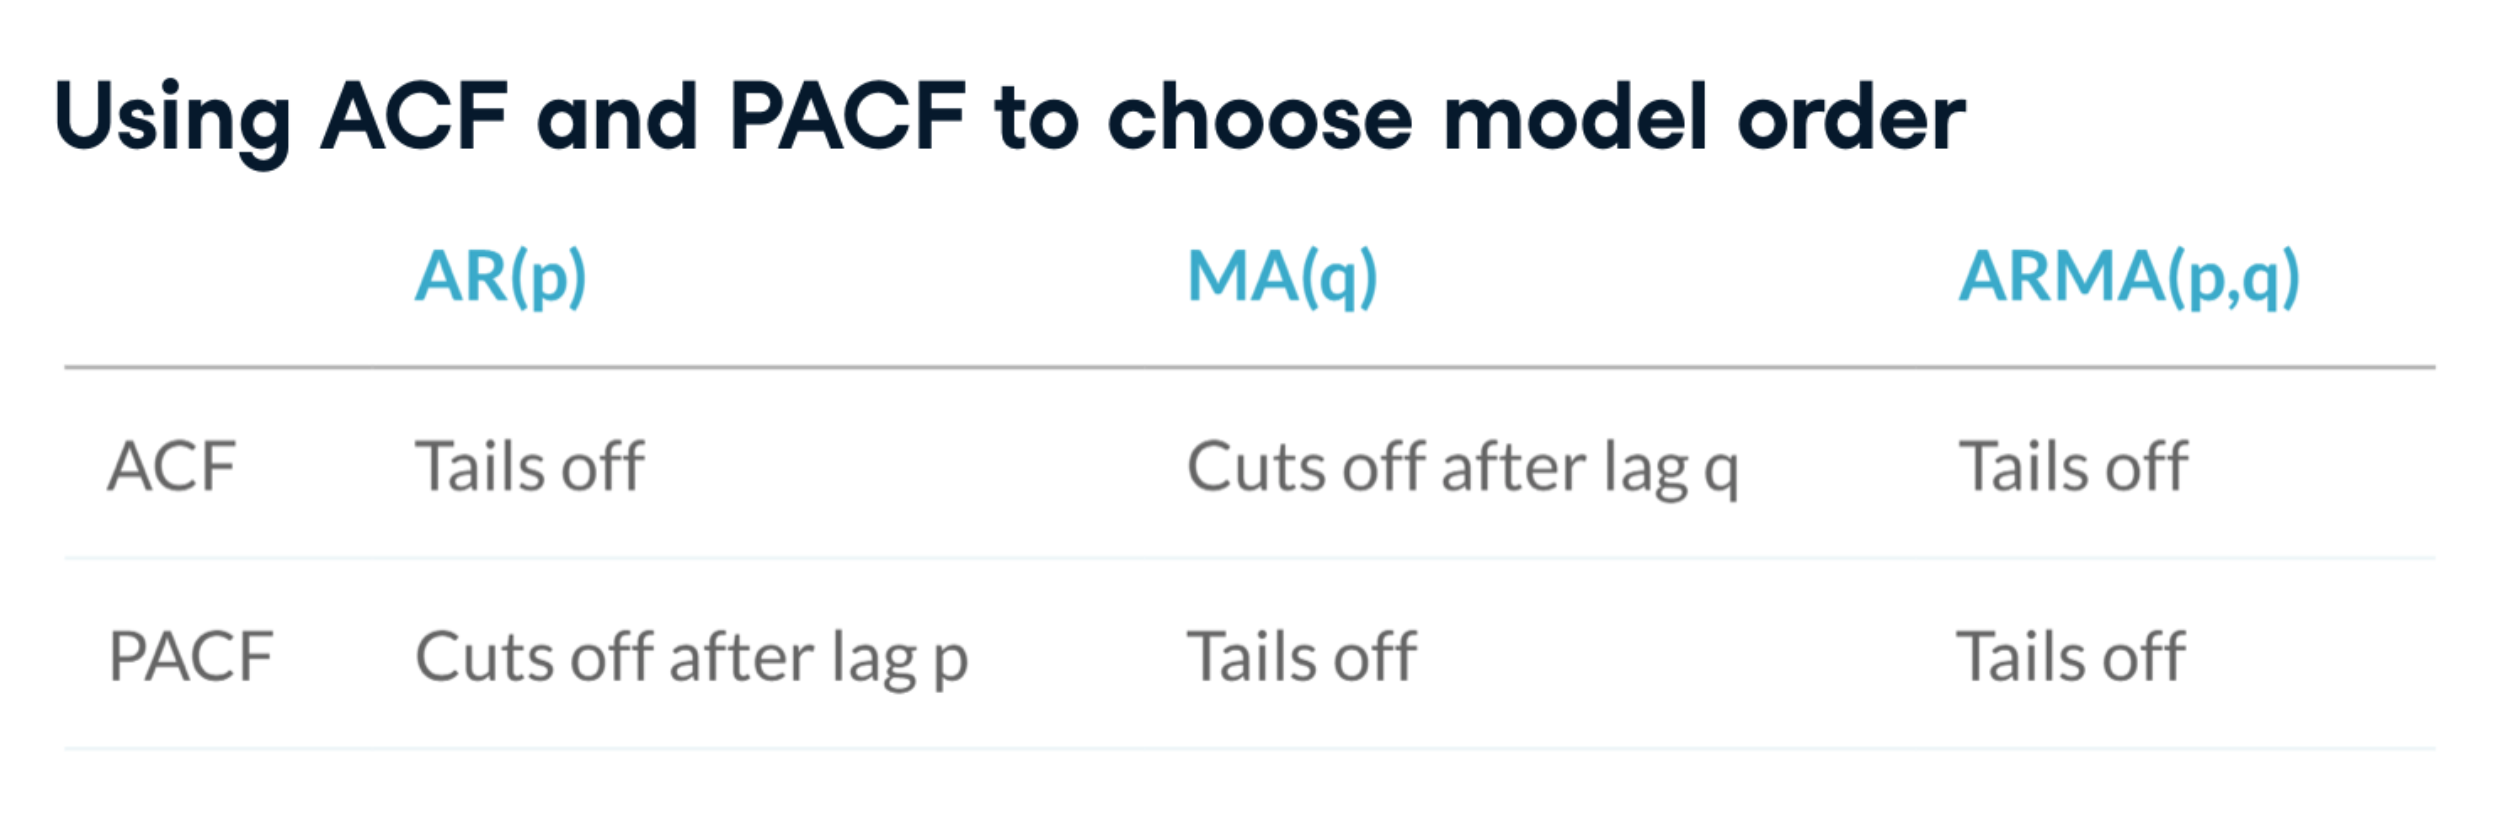

Looking at the table above, we can colclude that we have an ARMA model => we have to specify both p and q.

When both terms (p and q) are supposed to be nonzero, we can use AIC (Akaike information criterion) and BIC (Bayesian information criterion). For better forecasting model it is better to use AIC. BIC is better when searching for better explanatory model. 

I will write a loop which will help to deterine order of the model.

In [57]:
for p in range(6):
  for q in range(6):
    model_tr = SARIMAX(data, order=(p,1,q))
    model_tr_fit = model_tr.fit()

    print(p, q, model_tr_fit.aic, model_tr_fit.bic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

0 0 2572.4019362547688 2576.3315253981586
0 1 2384.031761079441 2391.8909393662207
0 2 2386.0027715316205 2397.79153896179
0 3 2387.9770693410783 2403.695425914638
0 4 2375.7111915192077 2395.359137236157


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0 5 2377.133223754693 2400.7107586150323
1 0 2472.5701722221356 2480.4293505089154
1 1 2386.002362129376 2397.7911295595454


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa

1 2 2385.1719531111025 2400.890309684662


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 3 2384.3045963714194 2403.952542088369


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 4 2376.458459922926 2400.0359947832653


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 5 2378.2705117547866 2405.7776357585158
2 0 2456.1315904412695 2467.920357871439


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 1 2387.9952132792146 2403.713569852774


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 2 2385.333445523268 2404.9813912402174


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 3 2377.2113941410253 2400.7889290013645


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 4 2377.334913592723 2404.842037596452


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 5 2378.972568982978 2410.409282130097
3 0 2411.6298689926516 2427.348225566211


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 1 2379.377318232065 2399.0252639490145


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 2 2379.9761050053694 2403.5536398657086


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 3 2380.5259526132113 2408.0330766169404


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 4 2376.180918107463 2407.617631254582


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmo

3 5 2377.7088150476457 2413.0751173381545
4 0 2407.4207519200872 2427.0686976370366
4 1 2380.9401261087214 2404.5176609690607


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 2 2381.961085772674 2409.468209776403


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 3 2380.7618957051995 2412.1986088523186


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 4 2377.0555041572416 2412.4218064477504


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 5 2379.222452788509 2418.518344222408
5 0 2397.433716772297 2421.0112516326362
5 1 2377.192422872001 2404.69954687573


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 2 2376.637040267583 2408.073753414702


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 3 2376.6786122970907 2412.0449145875996


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 4 2376.1821593612776 2415.4780507951764


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 5 2377.794343604901 2421.0198241821895


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Best aic result is gotten for p = 5 and q = 4

In [58]:
model = SARIMAX(data, order=(5,1,4))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         Deaths_per_day   No. Observations:                  377
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -1178.091
Date:                Wed, 03 Mar 2021   AIC                           2376.182
Time:                        20:21:30   BIC                           2415.478
Sample:                    01-22-2020   HQIC                          2391.781
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1431      0.168      0.853      0.393      -0.186       0.472
ar.L2         -0.5782      0.124     -4.654      0.000      -0.822      -0.335
ar.L3          0.1337      0.137      0.974      0.3

Interpretation of our ARIMA model:

( $Y_t = Y_{t-1} + e_t - 0.8205*e_{t-1}$ )  -  for auto arima model

<function matplotlib.pyplot.show>

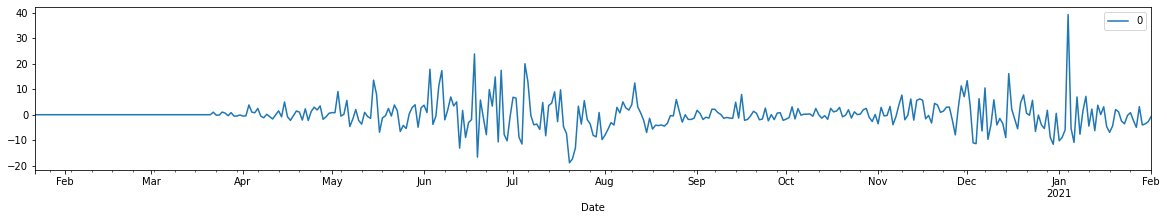

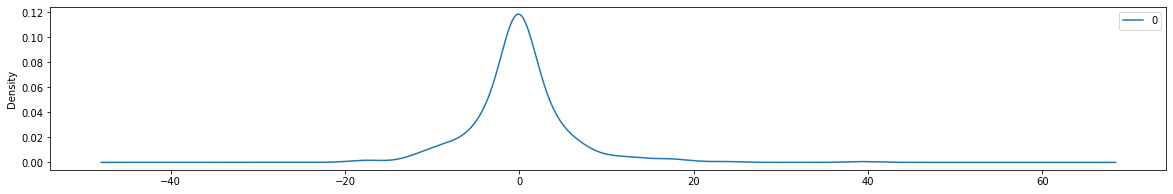

                0
count  377.000000
mean     0.032647
std      5.541564
min    -18.863669
25%     -1.975655
50%      0.000000
75%      1.854996
max     39.317560


In [59]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show

residuals.plot(kind='kde')
pyplot.show()

print(residuals.describe())

Figure(504x504)


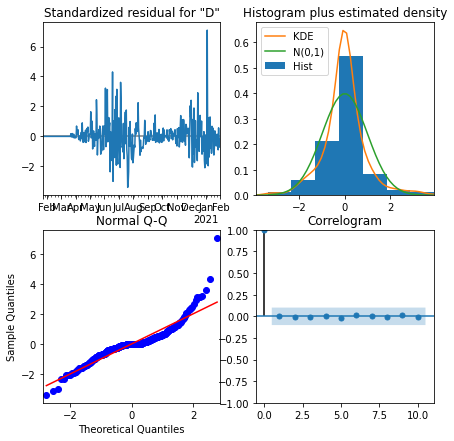

In [60]:
print(model_fit.plot_diagnostics(figsize=(7,7)))

Interpretation of residual plots:

1.
2.
3. Normal Q-Q : All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. => We can conclude that in our data disrtibution may be a little skewed.
4. 



**Accuracy metrics**

So here are some of the commonly used accuracy metrics for time-series data:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Min-Max Error (minmax)

Below we will get those metrics for our models

In [61]:
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast)   # MAPE
    me = np.mean(forecast - actual)                           # ME
    mae = mean_absolute_error(actual, forecast)               # MAE
    mpe = np.mean((forecast - actual)/actual)                 # MPE
    rmse = sqrt(mean_squared_error(actual, forecast))         # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                           # minmax
    
    return({'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 'minmax': minmax})


**Rolling Forecast ARIMA**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted = 2.140568, expected = 2.000000
predicted = 1.367402, expected = 0.000000
predicted = 2.108068, expected = 3.000000
predicted = 1.223938, expected = 2.000000
predicted = 2.537764, expected = 0.000000
predicted = 0.614696, expected = 0.000000
predicted = 1.142006, expected = 0.000000
predicted = 0.687936, expected = 4.000000
predicted = 1.633505, expected = 0.000000
predicted = 1.237724, expected = 4.000000
predicted = 1.253828, expected = 1.000000
predicted = 2.469971, expected = 2.000000
predicted = 1.052536, expected = 1.000000
predicted = 2.455498, expected = 2.000000
predicted = 1.316103, expected = 1.000000
predicted = 1.910092, expected = 4.000000
predicted = 1.958974, expected = 2.000000
predicted = 2.474499, expected = 1.000000
predicted = 1.340089, expected = 1.000000
predicted = 2.017057, expected = 0.000000
predicted = 1.112323, expected = 4.000000
predicted = 2.051293, expected = 3.000000
predicted = 2.467523, expected = 4.000000
predicted = 2.159105, expected = 5

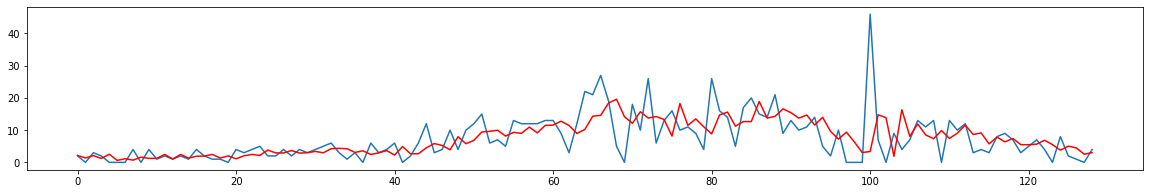

In [62]:
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = list(train[:])
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted = %f, expected = %f' % (yhat, obs))

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Forecast Accuracy**

In [63]:
print(forecast_accuracy(np.array(predictions), np.array(test)))

{'mape': 2882009733583385.0, 'me': 0.09927794208806875, 'mae': 4.062146022769952, 'mpe': inf, 'rmse': 6.36276086372312, 'minmax': 0.43951031216839354}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [64]:
pred = list()
test1 = list()

for i in range(len(test)):
    pred.append(int(predictions[i]))
    test1.append(int(test[i]))

print(f"Accuracy score: {accuracy_score(test1, pred)}")
print(f"R-squared: {round(sm.r2_score(test1, pred), 2)}")

Accuracy score: 0.12403100775193798
R-squared: 0.19
